In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors

from time import time

import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVC
sns.set_style("darkgrid")

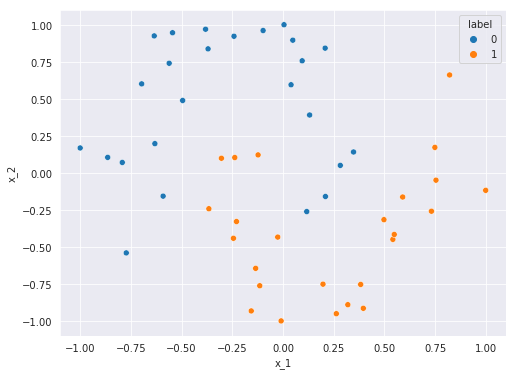

In [2]:
### Moonshape data
X,y = datasets.make_moons(n_samples=50, noise=0.2, random_state=10)

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

plt.figure(figsize=(8,6))
data_df = pd.DataFrame(dict(x_1=X[:,0], x_2=X[:,1], label=y))
sns.scatterplot('x_1', 'x_2', data=data_df, hue='label')
plt.show()

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state = 10,test_size=1/5)

### Quantum feature map

In [3]:
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=128)

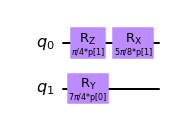

In [4]:
from qiskit.circuit import ParameterVector
p = ParameterVector('p', 2)  

qc = QuantumCircuit(2)

qc.rz((1/4)*np.pi*p[1],0)
qc.rx((5/8)*np.pi*p[1],0)
qc.ry((7/4)*np.pi*p[0],1)

test_kernel = QuantumKernel(feature_map=qc, quantum_instance=quantum_instance,)
qc.draw(output="mpl")

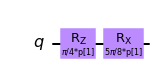

In [5]:
qc_1 = QuantumCircuit(1)
qc_1.rz((1/4)*np.pi*p[1],0)
qc_1.rx((5/8)*np.pi*p[1],0)

qc_1p = QuantumCircuit(1)
qc_1p += qc_1
qc_1p.p(0*p[0],0)
qc_1_kernel = QuantumKernel(feature_map=qc_1p, quantum_instance=quantum_instance,)
qc_1.draw(output="mpl")

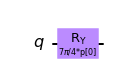

In [6]:
qc_2 = QuantumCircuit(1)
qc_2.ry((7/4)*np.pi*p[0],0)

qc_2p = QuantumCircuit(1)
qc_2p += qc_2
qc_2p.p(0*p[1],0)
qc_2_kernel = QuantumKernel(feature_map=qc_2p, quantum_instance=quantum_instance,)
qc_2.draw(output="mpl")

In [7]:
model_t = SVC(kernel=test_kernel.evaluate)
qsvm = model_t.fit(train_x, train_y)
q_score = model_t.score(test_x, test_y)

print(f'Test kernel score: {q_score}')

Test kernel score: 1.0


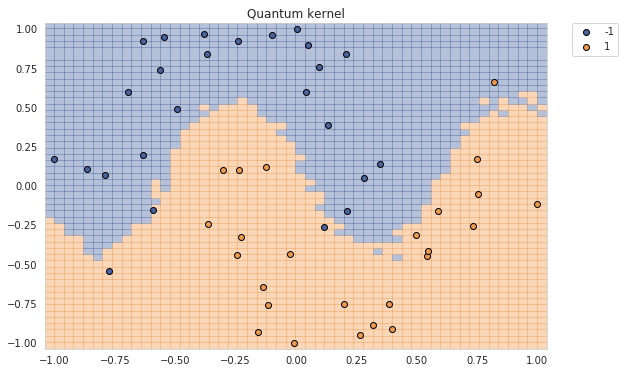

QSVM test score: 1.0
Cost time: 556.554674 s


In [8]:
GRID = 0.04

def make_big_meshgrid(x, y, h=GRID): 
    xx, yy = np.meshgrid(np.arange(-1.04, 1.04+GRID, h), np.arange(-1.04, 1.04+GRID, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X0, X1 = train_x[:, 0], train_x[:, 1]
bbxx, bbyy = make_big_meshgrid(X0, X1)
bbmeshgrid_features = np.column_stack((bbxx.ravel(), bbyy.ravel()))
meshgrid_time1 = time()

sns.set_style("whitegrid")
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#4863A0","#EE9A4D"])
meshgrid_colors = qsvm.predict(bbmeshgrid_features)

plt.figure(figsize=(9,6))
meshgrid_colors = meshgrid_colors.reshape(bbxx.shape)
plt.pcolormesh(bbxx, bbyy, meshgrid_colors, cmap=cmap, alpha=0.4)

plt.scatter(
    X[:, 0][y == 0],
    X[:, 1][y == 0],
    marker="o",
    facecolors="#4863A0",
    edgecolors="k",
    label="-1",)

plt.scatter(
    X[:, 0][y == 1],
    X[:, 1][y == 1],
    marker="o",
    facecolors="#EE9A4D",
    edgecolors="k",
    label="1",)

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Quantum kernel")
plt.show()

print(f'QSVM test score: {q_score}')

meshgrid_time2 = time()
print("Cost time: {:3f} s".format(meshgrid_time2-meshgrid_time1))

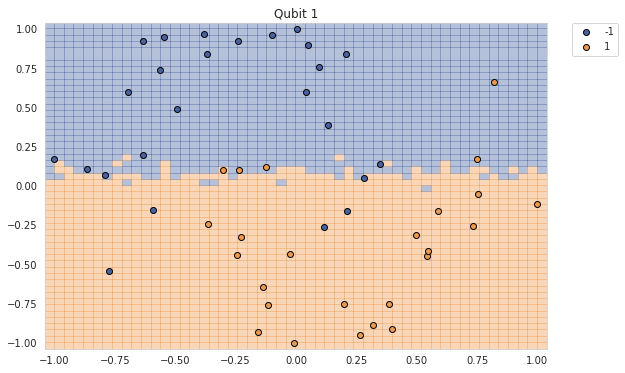

QSVM test score: 0.8
Cost time: 526.937701 s


In [9]:
model_t = SVC(kernel=qc_1_kernel.evaluate)
qsvm = model_t.fit(train_x, train_y)
q_score = model_t.score(test_x, test_y)

meshgrid_time1 = time()
meshgrid_colors = qsvm.predict(bbmeshgrid_features)

plt.figure(figsize=(9,6))
meshgrid_colors = meshgrid_colors.reshape(bbxx.shape)
plt.pcolormesh(bbxx, bbyy, meshgrid_colors, cmap=cmap, alpha=0.4)

plt.scatter(
    X[:, 0][y == 0],
    X[:, 1][y == 0],
    marker="o",
    facecolors="#4863A0",
    edgecolors="k",
    label="-1",)

plt.scatter(
    X[:, 0][y == 1],
    X[:, 1][y == 1],
    marker="o",
    facecolors="#EE9A4D",
    edgecolors="k",
    label="1",)

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Qubit 1")
plt.show()

print(f'QSVM test score: {q_score}')

meshgrid_time2 = time()
print("Cost time: {:3f} s".format(meshgrid_time2-meshgrid_time1))

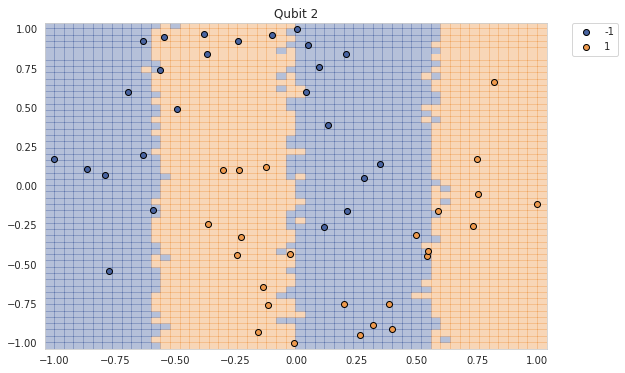

QSVM test score: 0.7
Cost time: 446.683244 s


In [10]:
model_t = SVC(kernel=qc_2_kernel.evaluate)
qsvm = model_t.fit(train_x, train_y)
q_score = model_t.score(test_x, test_y)

meshgrid_time1 = time()
meshgrid_colors = qsvm.predict(bbmeshgrid_features)

plt.figure(figsize=(9,6))
meshgrid_colors = meshgrid_colors.reshape(bbxx.shape)
plt.pcolormesh(bbxx, bbyy, meshgrid_colors, cmap=cmap, alpha=0.4)

plt.scatter(
    X[:, 0][y == 0],
    X[:, 1][y == 0],
    marker="o",
    facecolors="#4863A0",
    edgecolors="k",
    label="-1",)

plt.scatter(
    X[:, 0][y == 1],
    X[:, 1][y == 1],
    marker="o",
    facecolors="#EE9A4D",
    edgecolors="k",
    label="1",)

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Qubit 2")
plt.show()

print(f'QSVM test score: {q_score}')

meshgrid_time2 = time()
print("Cost time: {:3f} s".format(meshgrid_time2-meshgrid_time1))